## Database filtering

Data filtering the visual database related to rat's behavior - removal of movement interrupting acuity tests:
1. Rearing
2. Scratching
3. Moving around

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'
dfrat = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

## Data visualizaiton before filtering

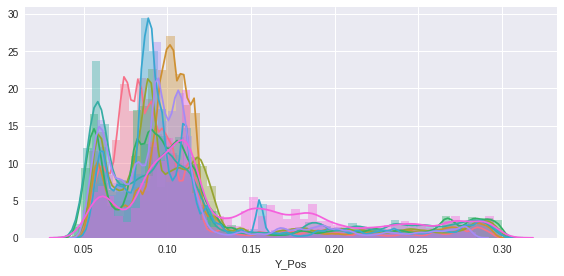

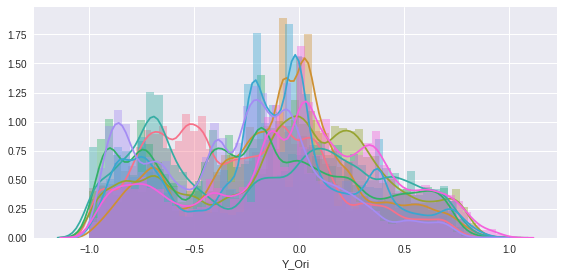

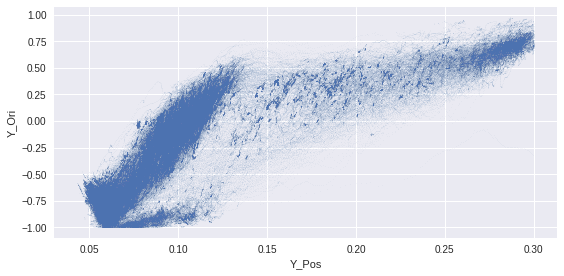

In [2]:
# postiion distribution visualization 
g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

# oritentation distribution visualization 
g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

# scatter between orientation and position
g = sns.FacetGrid( data=dfrat, size=4, aspect=2)
g.map(plt.scatter, "Y_Pos", "Y_Ori", alpha=0.1, s=0.1);


## Rearing removal
Removal based on Y axis postion limit - low pass filter

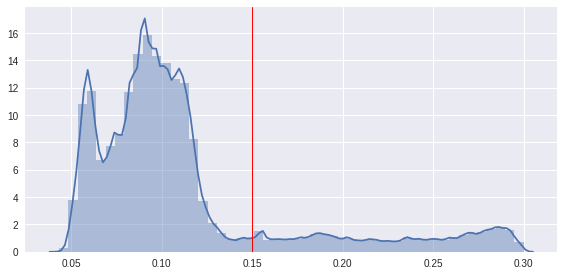

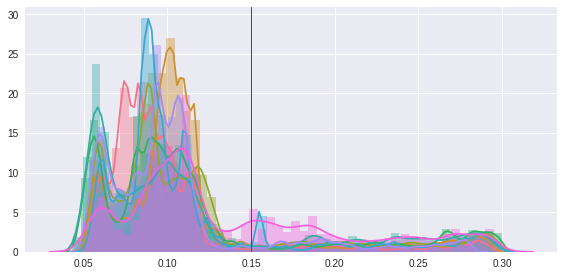

In [3]:
# postiion distribution visualization + suggested data cut
g = sns.FacetGrid(data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.15, alpha=1, linewidth=1, color='red');

g = sns.FacetGrid(hue='session_id', data=dfrat, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.15, alpha=1, linewidth=1, color='red');

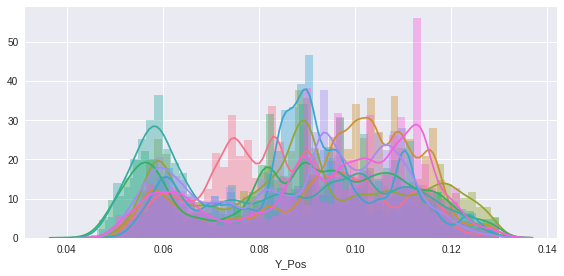

In [4]:
# Low pass filetring of Y position
rearinglimit = 0.13
dfratrear = dfrat[dfrat['Y_Pos'] < rearinglimit]

# Plotting after filtering
g = sns.FacetGrid(hue='session_id', data=dfratrear, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

## Scratching and cleaning removal
Removal based on Y axis orientation limit - high pass filter

MY THEORY: removing when Y_Ori and Y_Pos smaller then given limit
 1. both bumps in position and orietnation - rearing behavior
 2. remove based on bump detection in orientation
 3. cut off line: minimum distribution in half of the daya
 4. verifying if only that data is removed

goal: removing data where both position and orientation of the nose were very low


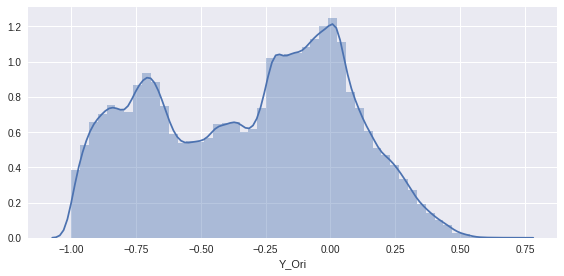

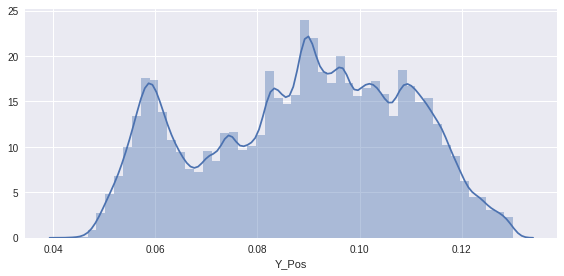

In [5]:
# distributions of all datasets
g = sns.FacetGrid(data=dfratrear, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');

g = sns.FacetGrid(data=dfratrear, size=4, aspect=2)
g.map(sns.distplot, 'Y_Pos');

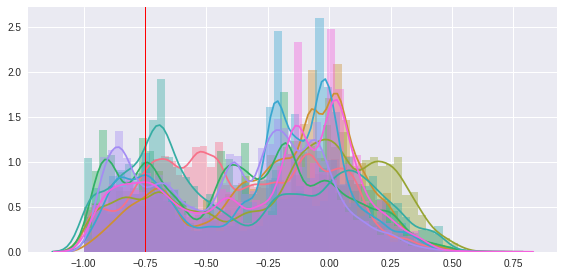

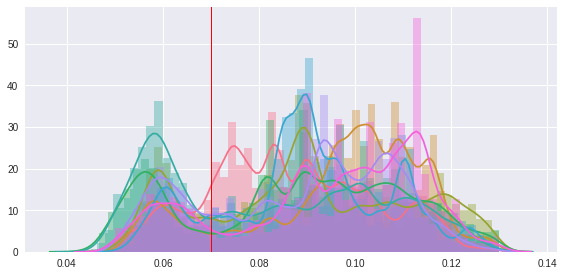

In [6]:
# distribution per experiment + filetered lines
g = sns.FacetGrid(hue='session_id', data=dfratrear, size=4, aspect=2)
g.map(sns.distplot, 'Y_Ori');
g.map(plt.axvline, x=-0.75, alpha=1, linewidth=1, color='red');

g = sns.FacetGrid(hue='session_id', data=dfratrear, size=4, aspect=2)#, hue_order=[4,5])
g.map(sns.distplot, 'Y_Pos');
g.map(plt.axvline, x=0.07, alpha=1, linewidth=1, color='red');


In [7]:
#filtering the dataset
dfratclean = pd.DataFrame()
for i, dd in dfratrear.groupby('session_id'):
    dd = dd[(dd['Y_Ori'] >-0.75) & (dd['Y_Pos'] > 0.07)]

    dfratclean = pd.concat([dfratclean, dd], axis=0, ignore_index=True)

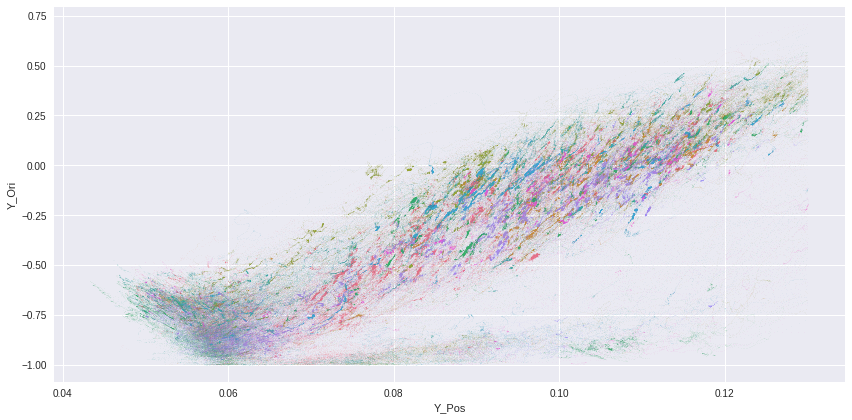

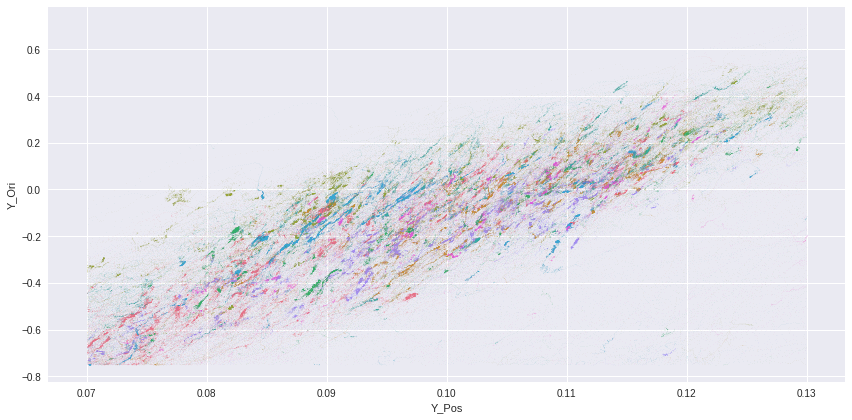

In [8]:
# relationship between position and orientation in Y axis before filtering
g = sns.FacetGrid( data=dfratrear, size=6, aspect=2, hue='session_id')
g.map(plt.scatter, "Y_Pos", "Y_Ori", alpha=0.1, s=0.1);

# relationship between position and orientation in Y axis after filtering
g = sns.FacetGrid( data=dfratclean, size=6, aspect=2, hue='session_id')
g.map(plt.scatter, "Y_Pos", "Y_Ori", alpha=0.1, s=0.1);

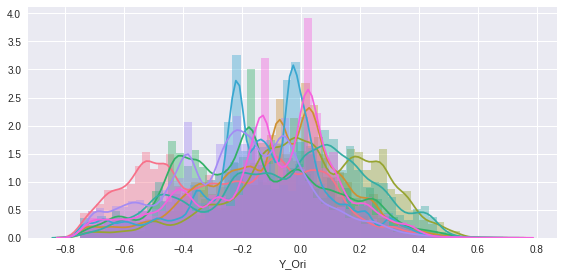

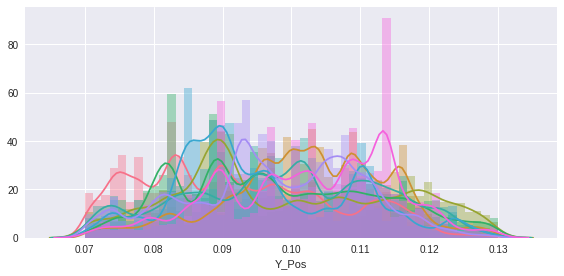

In [9]:
g = sns.FacetGrid(hue='session_id', data=dfratclean, size=4, aspect=2)#,hue_order=[0,1] )
g.map(sns.distplot, 'Y_Ori');

g = sns.FacetGrid(hue='session_id', data=dfratclean, size=4, aspect=2)#, hue_order=[0,1] )
g.map(sns.distplot, 'Y_Pos');


## Smoothing the data -  velocity verified

Rolling window applyed on X, Y, Z positiona and orientation data.

In [10]:
windowsize = 100
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

# for raw datasets
df = dfrat.copy()
g = df.groupby('session_id')
df[colChoice] = g[colChoice].rolling(window=windowsize).mean().values

# for filteres datasets
dfclean = dfratclean.copy()
g = dfclean.groupby('session_id')
dfclean[colChoice] = g[colChoice].rolling(window=windowsize).mean().values


In [11]:
## DATASETS FOR VISUALIZATION
pos_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')

# smoothed data
pos_lSM = df.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_lSM = df.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')

## DATASETS FOR VISUALIZATION AFTER FILTERING
pos_lclean = dfratclean.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_lclean = dfratclean.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')

# smoothed and filtered data
pos_lSMclean = dfclean.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Position', value_vars=['X_Pos', 'Y_Pos', 'Z_Pos'], var_name='Dimension')

ori_lSMclean = dfclean.melt(id_vars=['Frame', 'Time', 'session_id'], 
           value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


## Distribution

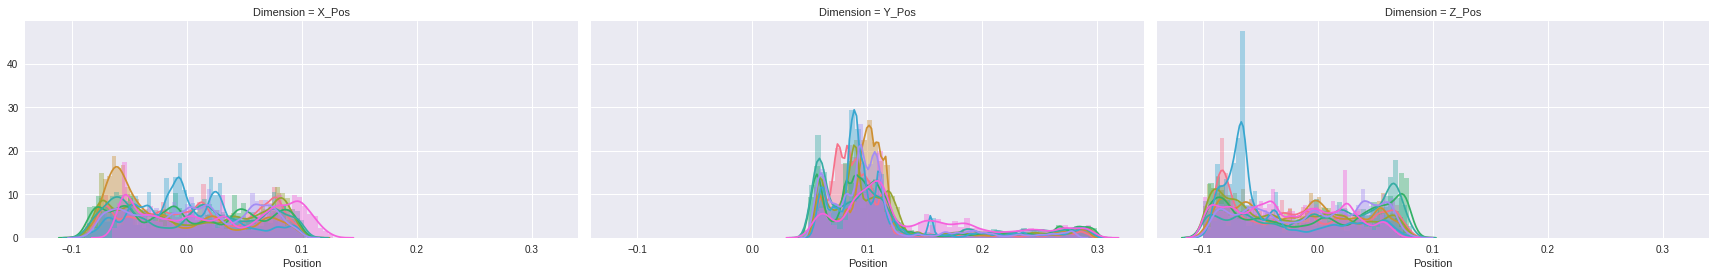

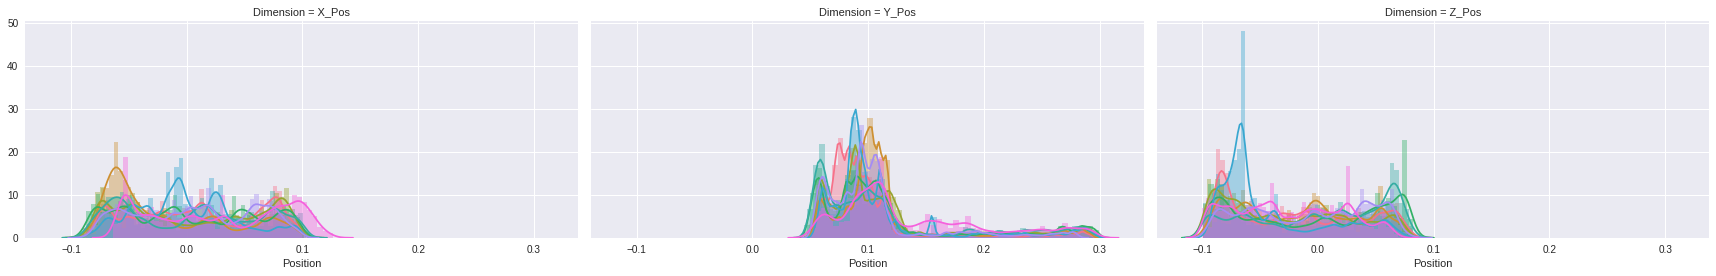

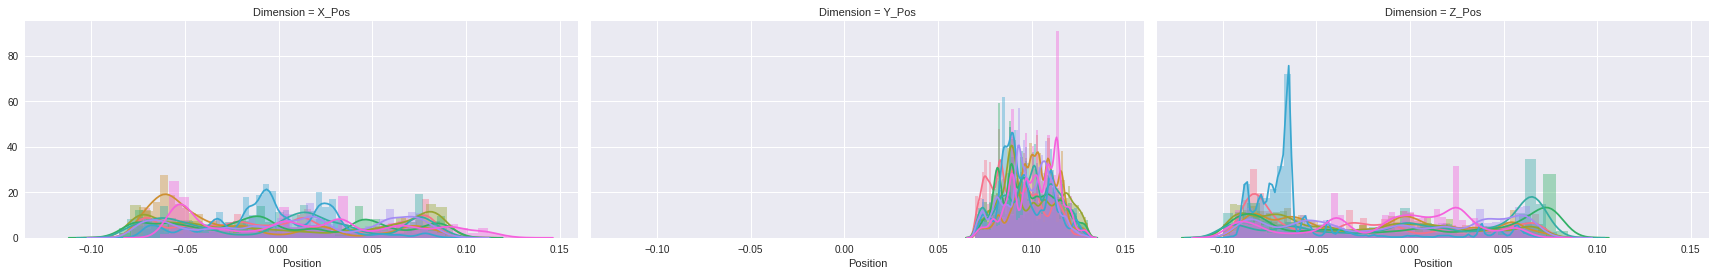

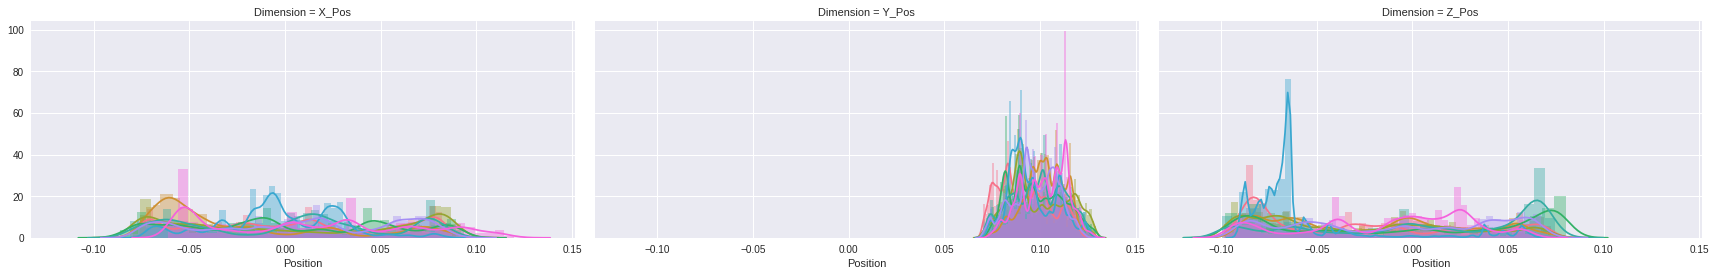

In [12]:
## POSITION
# original
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_l, size=4, aspect=2)
g.map(sns.distplot, 'Position');

# smoothed
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Position');

# filtered
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_lclean, size=4, aspect=2)
g.map(sns.distplot, 'Position');

# filtered + smoothed
g = sns.FacetGrid(hue='session_id', col='Dimension', data=pos_lSMclean, size=4, aspect=2)
g.map(sns.distplot, 'Position');

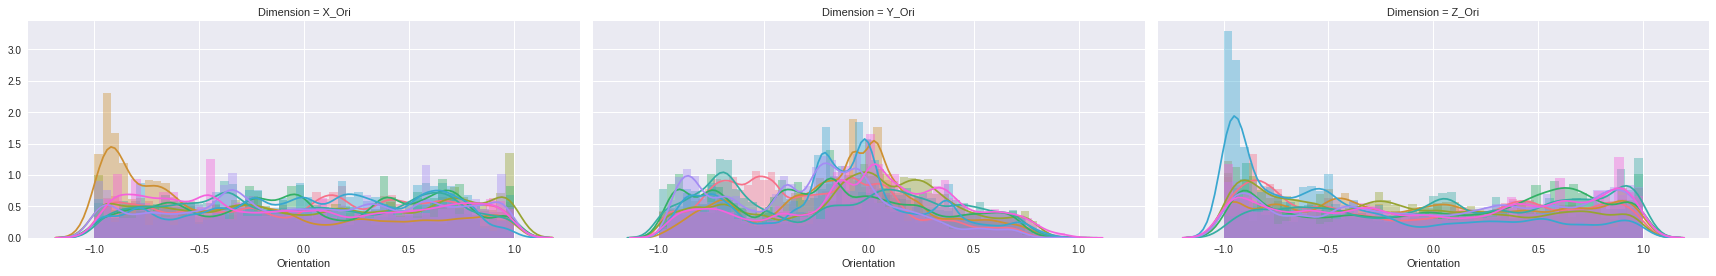

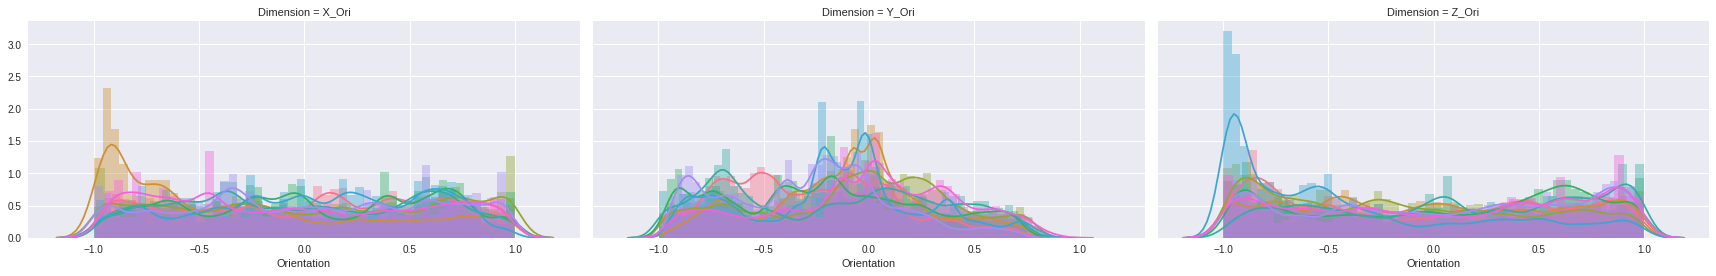

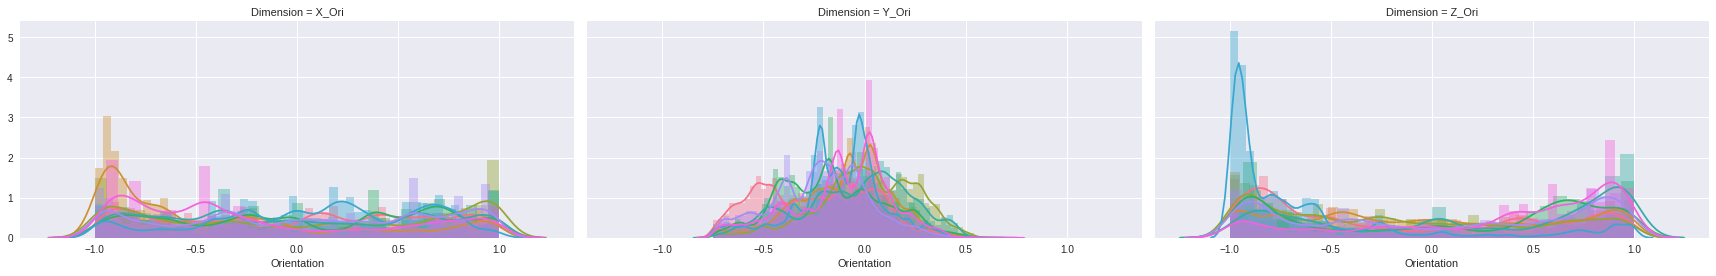

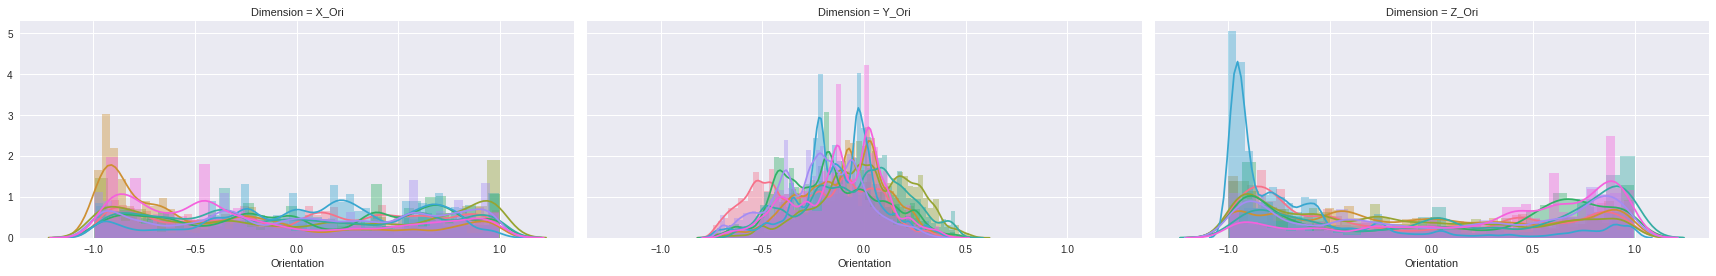

In [ ]:
## ORIENTATION
# original
g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_l, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');

# smoothed
g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_lSM, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');

# filtered
g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_lclean, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');

# filtered + smoothed
g = sns.FacetGrid(hue='session_id', col='Dimension', data=ori_lSMclean, size=4, aspect=2)
g.map(sns.distplot, 'Orientation');

## Velocity - rapid movement smooting check

In [ ]:
## ORIGINAL DATA
pd.options.mode.chained_assignment = None 

#extraction of speed of positon changes and calculating velocity in all axes
dfPos = pd.DataFrame()
dfV = df.copy().dropna()
colList = ['Time', 'X_Pos', 'Y_Pos', 'Z_Pos']
dcolList = ['dT', 'dX_Pos', 'dY_Pos', 'dZ_Pos']

for name, dd in dfV.groupby('session_id'):
    dd[dcolList] = dd[colList].diff(-1)    
    dd['Vx_Pos'] = dd['dX_Pos'] / dd['dT']
    dd['Vy_Pos'] = dd['dY_Pos'] / dd['dT']
    dd['Vz_Pos'] = dd['dZ_Pos'] / dd['dT']
    dd['Vxyz_Pos'] = np.linalg.norm(dd[['Vx_Pos', 'Vy_Pos', 'Vz_Pos']].values, axis=1) # diagonal velocity   

    dfPos = pd.concat([dfPos, dd], axis=0, ignore_index=True)

dfPos = dfPos.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
## POSITION VXYZ VELOCITY
g = sns.FacetGrid(hue='session_id', data=dfPos, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "Vxyz_Pos", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfPos, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'Vxyz_Pos');


In [ ]:
## FILTERED DATA
pd.options.mode.chained_assignment = None 

#extraction of speed of positon changes and calculating velocity in all axes
dfPosclean = pd.DataFrame()
dfVclean = dfclean.copy().dropna()
colList = ['Time', 'X_Pos', 'Y_Pos', 'Z_Pos']
dcolList = ['dT', 'dX_Pos', 'dY_Pos', 'dZ_Pos']

for name, dd in dfVclean.groupby('session_id'):
    dd[dcolList] = dd[colList].diff(-1)    
    dd['Vx_Pos'] = dd['dX_Pos'] / dd['dT']
    dd['Vy_Pos'] = dd['dY_Pos'] / dd['dT']
    dd['Vz_Pos'] = dd['dZ_Pos'] / dd['dT']
    dd['Vxyz_Pos'] = np.linalg.norm(dd[['Vx_Pos', 'Vy_Pos', 'Vz_Pos']].values, axis=1) # diagonal velocity   

    dfPosclean = pd.concat([dfPosclean, dd], axis=0, ignore_index=True)

dfPosclean = dfPosclean.replace([np.inf, -np.inf], np.nan).dropna()

In [ ]:
## POSITION VXYZ VELOCITY
g = sns.FacetGrid(hue='session_id', data=dfPosclean, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "Vxyz_Pos", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfPosclean, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'Vxyz_Pos');
